# Time Series Forecasting

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas.plotting._converter as pandacnv
pandacnv.register()

In [2]:
from os import walk

for d, _, files in walk('./data'):
    for f in files:
        print(d+'/'+f)

./data/CalIt2.names
./data/Dodgers.events
./data/CalIt2.events
./data/Dodgers.data
./data/CalIt2.data
./data/Dodgers.names


From `data/Dodgers.names`

>6. Dodgers.data file format:
> (column)
>  1.  Date: MM/DD/YY
>  2.  Time: (H)H:MM (military time)
>  3.  Count: Number of cars measured for the previous five minutes
>  Rows: Each five minute time slice is represented by one row
>
>7. Dodgers.events format:
> (column)
>  1.  Date: MM/DD/YY
>  2.  Begin event time: HH:MM:SS (military)
>  3.  End event time: HH:MM:SS (military)
>  4.  Game attendance
>  5.  Away team
>  6.  W/L score
>
>8. Missing Attribute Values: 2903 (represented by -1)

In [3]:
df = pd.read_csv('data/Dodgers.data',header=None,names=['Date', 'Count'],index_col=0)
df.index = pd.to_datetime(df.index)

We can see we are going to have some problem with the '-1' data immediately, and this is going to cause problems with the predictions.

In [4]:
def print_missed_entries(gdf):
    total_elements = len(gdf)
    num_missed = gdf.where(gdf['Count'] == -1).count()['Count']
    perc_missed = (num_missed / total_elements) * 100

    print('{} missed entries of {} total entries: {:0.2f}% missed'.format(num_missed, total_elements, perc_missed)) 

In [5]:
print_missed_entries(df)

2903 missed entries of 50400 total entries: 5.76% missed


In [6]:
# We will take the -1 at the beginning and the end to begin.
first_real_entry = df[df.Count > 0].index[0]
last_real_entry = df[df.Count > 0].index[-1]
df = df[first_real_entry:last_real_entry]

In [7]:
print_missed_entries(df)

2238 missed entries of 49735 total entries: 4.50% missed


This is a good initial drop, but we still have to deal with the embedded data points that have missing values. What we are going to do to alleviate this issue is retrieve the average car count at that particular minute over the day, and fill in those values accordingly. This should be reasonable because We are keeping a fine level of granularity and trying to keep busier minutes of the day to have more traffic.

In [8]:
min_time = df.index.min()
max_time = df.index.max()
num_five_min_intervals = 12 * 24 # each day can be broken up into 12x24 = 288 5-minute-intervals

avg_score = {}
for i in range(num_five_min_intervals):
    mean = df.loc[np.arange(min_time, max_time, dtype='datetime64[D]') + np.timedelta64(5*i,'m')] \
                .where(df['Count']>0).mean()['Count']
    avg_score[i] = mean

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  import sys


In [9]:
df.sum()

Count    991167
dtype: int64

In [10]:
for index, val in df.iterrows():
    if val[0] == -1:
        dt = index.to_pydatetime() 
        replace_val = int(dt.hour * 12 + dt.minute / 5)
        df.at[index,'Count'] = avg_score[replace_val]

In [11]:
df.sum()

Count    1035116
dtype: int64

We can look at the lag plot to see if there is any sort of correlation between neighbouring points. This is a good sign to see if we can perform some sort of time series forecasting.

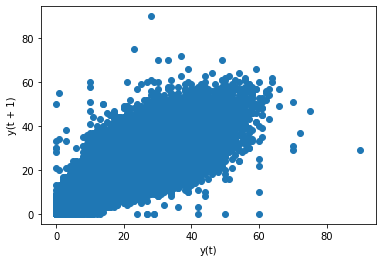

In [12]:
from pandas.plotting import lag_plot
lag_plot(df)
plt.show()

The lag plot shows that there clearly is some sort of autocorrelation between the last five minutes and the following five. This makes sense, as traffic will not change that much over the course of 5 minutes. However, we are not interested in the predictions down to that level. We are instead interested in daily traffic levels. This would allow for planning of roadwork, number of traffic officers needed, and more. We'll go in and only look at the day levels.

In [13]:
df = df['2005-04-12':'2005-09-30'] # get rid of partial days

In [14]:
df = df.groupby(df.index.date).sum()

Now, we have the traffic count grouped by day. This is the starting point for our time series prediction.

### Method 1: SARIMA

SARIMA stands for Seasonal AutoRegressive Integrated Moving Average model. The model is composed of:
- AutoRegressive model (checks to see if the count of previous points can predict a future point)
- Moving Average Model (checks to see if the error can predict a future value)

These two combined form the ARMA model, but this is limited to stationary (no change in variance / mean), non seasonal model. We know that traffic follows a weekly pattern, so there will be a sesonal component to it. If the variance/mean changes, then we need to use the ARIMA model to account for the non-stationary factor in the data. If there is some sort of seasonality, then we need to expand to a SARIMA model.

We start by looking at the ACF and PACF plots to determine valuable parameters for Sarima(p,d,q)(P,D,Q)m

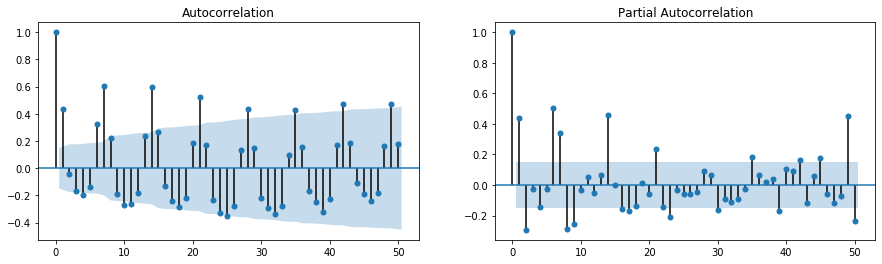

In [15]:
import statsmodels.api as sm

fig, axes = plt.subplots(1, 2, figsize=(15,4))

num_lags = 50
fig = sm.graphics.tsa.plot_acf(df['Count'], lags=num_lags, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(df['Count'], lags=num_lags, ax=axes[1])

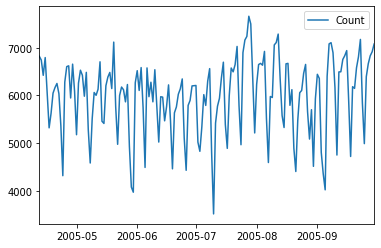

In [16]:
df.plot()

By looking at the autocorrelation plot, we immediately see there is a seasonal component to this data, which repeats every week. This makes sense, because people typically follow some sort of weekly schedule. Because of this seasonality, we are going to start out modelling by creating a SARIMA model (Seasonal Autoregressive Integrated Moving Average).

Then to choose the (p,d,q)(P,D,Q) we can use box-jenkins method. There doesn't seem to be any sort of change in mean or variance, so we will set d and D to zero. 

Looking at the plots, we will try using using SARIMA(3,0,1)(1,0,3)12

We are going to split our model into a Train and Test data set, where we try to predict one months worth of traffic. The train data will be all but the final months traffic.

In [17]:
forecast_size = 30
train, test = df['Count'][:-forecast_size], df['Count'][-forecast_size:]

# Fit the model
mod = sm.tsa.statespace.SARIMAX(train, order=(3,0,1), seasonal_order=(1,0,3,7))
res = mod.fit(disp=False)

print(res.summary())

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                
Dep. Variable:                             Count   No. Observations:                  142
Model:             SARIMAX(3, 0, 1)x(1, 0, 3, 7)   Log Likelihood               -1068.167
Date:                           Sun, 20 Oct 2019   AIC                           2154.334
Time:                                   19:49:32   BIC                           2180.937
Sample:                               04-12-2005   HQIC                          2165.144
                                    - 08-31-2005                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5462      0.072     21.579      0.000       1.406       1.687
ar.L2         -0.3745      0.150     -2.498

/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [18]:
# In-sample one-step-ahead predictions
prediction_range = (test.index[0], test.index[-1])
predict = res.predict(*prediction_range)

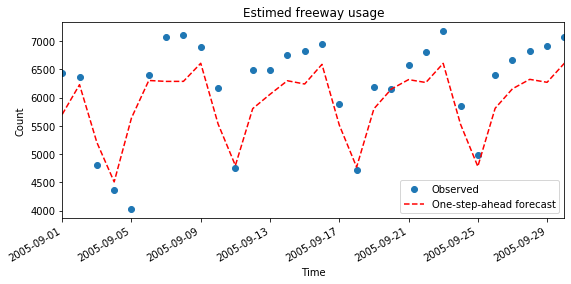

In [19]:
# Graph
fig, ax = plt.subplots(figsize=(9,4))
npre = 4
ax.set(title='Estimed freeway usage', xlabel='Time', ylabel='Count')

# Plot data points
test.plot(ax=ax, style='o', label='Observed')

# Plot predictions
predict.plot(ax=ax, style='r--', label='One-step-ahead forecast')

legend = ax.legend(loc='lower right')

We can see our prediction is approximately following the data set. It is not extending high enough on the high end, and not dipping enough of the low end. However, it is capturing the overall data trends quite well. We will capture the Root Mean Square Error, to be able to compare this technique to future techniques.

In [20]:
from sklearn.metrics import mean_squared_error
from math import sqrt

error = sqrt(mean_squared_error(test, predict))

print('Test Score: %.2f RMSE' % (error))

Test Score: 551.42 RMSE


In [21]:
def retrive_cum_rmse(test,predict):
    """Reterive the cumulative Root Mean Square Error between a test dataset and real values.
    """
    cum_err = np.cumsum(np.sqrt((test - predict)**2))
    for i in range(len(cum_err)):
        cum_err[i] /= i+1
    return cum_err
    

In [22]:
sarima_err = retrive_cum_rmse(test.values, predict.values)

Voila! We have fit a SARIMA model to the data. Next step, we move away from the logically sound model to a more biological manner, by using artificial Neural Networks.

## LSTM
The next type of prediction we are going to do is to use Long-short tem predictions. We are going to need to use Keras in order to set up our LSTM model, so we start by importing all the impodule classes.

In [23]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


We are going to want to normalize the data to fall between 0 and 1 to use in the LSTM.

In [24]:
# normalize the dataset
dataset = df.values
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
look_back=14

train, test = dataset[:-forecast_size], dataset[-forecast_size-look_back-1:]

In [25]:
def create_dataset(dataset, look_back=1):
    '''Wrapper to transform a numpy.ndarray into a format to be used with keras.layers.LSTM
    
    Parameters
    -------
    dataset : numpy.ndarray
        Data values of historic, equal spaced points
    lookback : int
        Number of datapoints required to lookback (Default is 1)
    
    Returns
    -------
    tuple<numpy.ndarray,numpy.ndarray>
        Tuple, with the first entry being the data set, and the second is the next predicted value.
    '''
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    dataX = np.array(dataX)
    dataY = np.array(dataY)
    
    dataX = np.reshape(dataX, (dataX.shape[0], 1, dataX.shape[1]))
    dataY = dataY.reshape(-1,1)
    return dataX, dataY

In [26]:
trainX, trainY = create_dataset(train, look_back=look_back)
resultsY = scaler.inverse_transform(trainY)

In [27]:
# create and fit the LSTM network
model = Sequential([
    LSTM(1, input_shape=(1,look_back))
])
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

In [28]:
testX, testY = create_dataset(test, look_back)
testY = scaler.inverse_transform(testY)

In [29]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

# calculate root mean squared error
trainScore = sqrt(mean_squared_error(resultsY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 477.76 RMSE
Test Score: 625.36 RMSE


In [30]:
lstm_err = retrive_cum_rmse(testY, testPredict)

In [31]:
def plot_data():
    # Graph
    fig, ax = plt.subplots(figsize=(9,4))
    npre = 4
    ax.set(title='Estimed freeway usage', xlabel='Time', ylabel='Count')

    # Plot data points
    ax.plot(testY, 'o', label='Observed')

    # Plot predictions
    ax.plot(testPredict, 'r--', label='LSTM prediction')
    ax.legend(loc='lower right')

    plt.show()

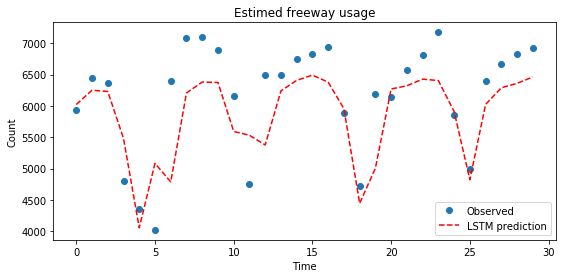

In [32]:
plot_data()

Now, we can see this is slightly worse than the ARIMA model. The RMSE on the test data has increased from 551.42 to 639.67. We can try to put in another dense layer into our model to correct some of this behavior. Currently, the LSTM is only outputting a scalar value, making it tough to retain state and removing a strong feature of the LSTM. 

We want to recall what the average value is for that day of the week, so lets make the LSTM output a 7dim vector, and then attach a dense layer to turn that into a single scalar value.

In [33]:
# create and fit the LSTM network
modelDense = Sequential()
modelDense.add(LSTM(7, input_shape=(1,look_back)))
modelDense.add(Dense(1))
modelDense.compile(loss='mean_squared_error', optimizer='adam')
modelDense.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

In [34]:
# make predictions
trainPredict = modelDense.predict(trainX)
testPredict = modelDense.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

# calculate root mean squared error
trainScore = sqrt(mean_squared_error(resultsY, trainPredict))
print('Train Score LSTM with dense: %.2f RMSE' % (trainScore))
testScore = sqrt(mean_squared_error(testY, testPredict))
print('Test Score LSTM with dense: %.2f RMSE' % (testScore))

Train Score LSTM with dense: 412.67 RMSE
Test Score LSTM with dense: 479.71 RMSE


In [35]:
dense_lstm_err = retrive_cum_rmse(testY, testPredict)

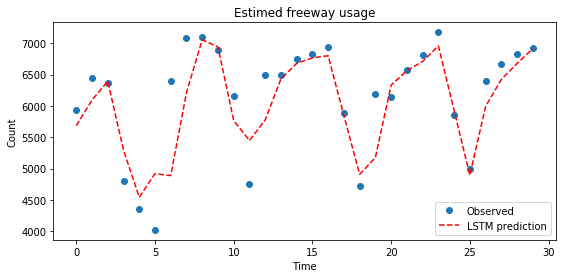

In [36]:
plot_data()

Now that we have stored additional state within the LSTM, we can see that we have reduced our test score from 639.67 to 576.46. We still are not beating the ARIMA model though. We have added ability to retain 7 pieces of information, instead of just one. This makes sense, because there are seven days of the week and we should keep track of something related to the seven days.

In order to beat the ARIMA model, it is reasonable to assume we need more data. Our dataset currently only has 127 points, which is incredibly small, for trying to forecast one month into the future.

### Dropout
Now, lets try adding some dropout. I am trying this for the sake of experimenting with dropout, but I do not believe this will add any value, due to the sparsity of the data.

In [37]:
from keras.layers import Dropout

In [38]:
# create and fit the LSTM network
modelDropout = Sequential()
modelDropout.add(LSTM(7, input_shape=(1,look_back)))
modelDropout.add(Dropout(0.5))
modelDropout.add(Dense(1))
modelDropout.compile(loss='mean_squared_error', optimizer='adam')
modelDropout.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

In [39]:
# make predictions
trainPredict = modelDropout.predict(trainX)
testPredict = modelDropout.predict(testX)

In [40]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

# calculate root mean squared error
trainScore = sqrt(mean_squared_error(resultsY, trainPredict))
print('Train Score LSTM with dense: %.2f RMSE' % (trainScore))
testScore = sqrt(mean_squared_error(testY, testPredict))
print('Test Score LSTM with dense: %.2f RMSE' % (testScore))

Train Score LSTM with dense: 461.44 RMSE
Test Score LSTM with dense: 567.09 RMSE


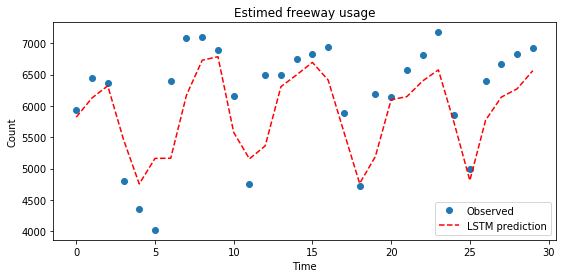

In [41]:
plot_data()

In [42]:
dropout_lstm_err = retrive_cum_rmse(testY, testPredict)

### Time Delayed Neural Networks TDNN

In [47]:
from keras.layers import Conv1D, MaxPooling1D, Flatten

In [59]:
modelConv = Sequential()
modelConv.add(Conv1D(32, kernel_size=(1,), activation='relu', input_shape=(1,look_back)))
modelConv.add(Dropout(0.5))
modelConv.add(MaxPooling1D(pool_size=2))
modelConv.add(Flatten())
modelConv.add(Dense(7, activation='relu'))
modelConv.add(Dense(1, activation='softmax'))
modelConv.compile(loss='mean_squared_error', optimizer='adam')
# fit network
modelConv.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)

ValueError: Negative dimension size caused by subtracting 2 from 1 for 'max_pooling1d_3/MaxPool' (op: 'MaxPool') with input shapes: [?,1,1,32].

In [52]:
# make predictions
trainPredict = modelConv.predict(trainX)
testPredict = modelConv.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

# calculate root mean squared error
trainScore = sqrt(mean_squared_error(resultsY, trainPredict))
print('Train Score LSTM with dense: %.2f RMSE' % (trainScore))
testScore = sqrt(mean_squared_error(testY, testPredict))
print('Test Score LSTM with dense: %.2f RMSE' % (testScore))

Train Score LSTM with dense: 1887.06 RMSE
Test Score LSTM with dense: 1725.44 RMSE


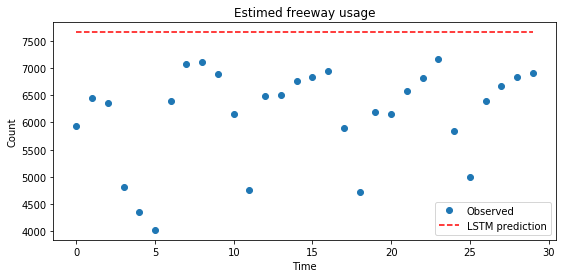

In [53]:
plot_data()

### Comparison

Now, we can start looking at the differences between the models. We have chosen to keep track of the cumulative rmse of the test data.

In [ ]:
fig, ax = plt.subplots(figsize=(9,4))
npre = 4
ax.set(title='Estimed freeway usage', xlabel='Time', ylabel='RMSE')
ax.plot(sarima_err, 'r', label='SARIMA(3,0,1)(1,0,3)7')
ax.plot(lstm_err, 'b', label='LSTM')
ax.plot(dense_lstm_err, 'g', label='Dense LSTM')
ax.plot(dropout_lstm_err, 'y', label='Dropout LSTM')


legend = ax.legend(loc='lower right')

We see that our initial few prediction in the LSTM models actually are more accurate than the SARIMA model. However, once we extend the time the ARIMA model has a slight benefit, but the three models apear to be converging.

To better our models, I would say that we would need to gather more data to make our LSTM behave better. Our dataset is very small, so the error is still high in the LSTM.